In [1]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from skimage.metrics import structural_similarity
from skimage.metrics import normalized_root_mse
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


**DISCRIMINATOR**

Patch-GAN: To generate an error with source and outcome as inputs, so that it is conditionally dependent on what it _should_ look like given a certain input.

In [2]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [3]:
discriminator = define_discriminator((256,256,3))
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 6208        concatenate_1[0][0]        

**GENERATOR**

Define a U-Net encoder and decoder block functions. The skip connections are to reinforce the reconstruction of the coloured image.

In [4]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [5]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [6]:
generator = define_generator()
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_6[0][0]              
____________________________________________________________________________________________

**GAN**

Stacking the generator and discriminator to build the actual GAN model.

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [8]:
gan = define_gan(generator, discriminator, (256,256,3))
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 256, 256, 3)  54429315    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 16, 16, 1)    6968257     input_4[0][0]                    
                                                                 model_2[1][0]                    
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
__________________________________________________________________________________________________


**DATA HANDLING**

We need to load and generate real source (SAR) and target (RGB) images from our dataset. Due to the size, we cannot load it entirely into memory and will have to load the images on demand.

The images have to be generalized over four seasons and different geographic locations. Therefore, we build a function to randomly select a season and then randomly select an SAR image and its corresponding optical image pair.

In [9]:
# import numpy as np

# def get_images(batch_size):
    
#     base_path = 'munich/'
    
#     #select season
#     files = listdir(base_path)
# #     print(files)
#     files_len = len(files)
# #     print(files_len)
#     rint1 = np.random.randint(0, files_len)
# #     print(rint1)
#     lvl1 = files[rint1]
# #     print(lvl1)
    
#     #select SAR image folder
#     files = listdir(base_path + lvl1 + '/s1/')
#     files_len = len(files)
# #     print(files_len)
#     rint2 = np.random.randint(0, files_len)
# #     print(rint2)
#     lvl2 = files[rint2]
# #     print(lvl2)
    
#     #select SAR image
#     s1_path = base_path + lvl1 + '/s1/' + lvl2 + '/'
#     files = listdir(s1_path)
#     files_len = len(files)
# #     print(files_len)
#     rint3 = np.random.randint(0, files_len, batch_size)
# #     print(rint3)
#     files_arr = np.array(files)
#     lvl3 = files_arr[rint3]
# #     print(lvl3)
    
#     #select RGB image
#     temp2 = lvl2.replace('s1', 's2')
#     lvl3_opt = lvl3.tolist()
#     temp3 = [sub.replace('_s1_', '_s2_') for sub in lvl3_opt]
# #     print(temp2)
# #     print(temp3)
#     s2_path = base_path + lvl1 + '/s2/' + temp2 + '/'
# #     print(s2_path)
    
#     #load images
#     img_sar=[]
#     img_opt=[]
#     for i in range(batch_size):
#         img = load_img(s1_path + lvl3[i])
#         img = img_to_array(img)
#         img_sar.append(img)
#         img = load_img(s2_path + temp3[i])
#         img = img_to_array(img)
#         img_opt.append(img)
        
#     img_sar = np.array(img_sar)
#     img_opt = np.array(img_opt)
#     img_sar = (img_sar - 127.5) / 127.5
#     img_opt = (img_opt - 127.5) / 127.5
    
#     return img_sar, img_opt

In [10]:
import numpy as np
import random

def shuff():
    
    #select SAR image
    s1_path = 'munich/train/s1/'
    files = listdir(s1_path)
    random.shuffle(files)
    return files

In [11]:
# paper satellite run
import numpy as np

def get_images(batch_size, files, i):
    
    sar_img_name = files[i]
    
    img_sar=[]
    img_opt=[]
    
    s1_path = 'munich/train/s1/'
    img = load_img(s1_path + sar_img_name)
    img = img_to_array(img)
    img_sar.append(img)
    
    #select RGB image
    opt_img_name = sar_img_name.replace('_s1_', '_s2_', 1)
#     temp = ""
#     temp.join(opt_img_name)
    
    s2_path = 'munich/train/s2/'
    img = load_img(s2_path + opt_img_name)
#     img = load_img(s2_path + temp)
    img = img_to_array(img)
    img_opt.append(img)
    
    img_sar = np.array(img_sar)
    img_opt = np.array(img_opt)
    img_sar = (img_sar - 127.5) / 127.5
    img_opt = (img_opt - 127.5) / 127.5
    
    return img_sar, img_opt

In [12]:
# # satellite run
# import numpy as np

# def get_images(batch_size, files):
    
#     #select SAR image
#     s1_path = 'munich/train/s1/'
#     files = listdir(s1_path)
#     files_len = len(files)
# #     print(files_len)
#     rint3 = np.random.randint(0, files_len, batch_size)
# #     print(rint3)
#     files_arr = np.array(files)
#     lvl3 = files_arr[rint3]
# #     print(lvl3)
    
#     #select RGB image
#     lvl3_opt = lvl3.tolist()
#     temp3 = [sub.replace('_s1_', '_s2_') for sub in lvl3_opt]
# #     print(temp3)
#     s2_path = 'munich/train/s2/'
    
#     #load images
#     img_sar=[]
#     img_opt=[]
#     for i in range(batch_size):
#         img = load_img(s1_path + lvl3[i])
#         img = img_to_array(img)
#         img_sar.append(img)
#         img = load_img(s2_path + temp3[i])
#         img = img_to_array(img)
#         img_opt.append(img)
        
#     img_sar = np.array(img_sar)
#     img_opt = np.array(img_opt)
#     img_sar = (img_sar - 127.5) / 127.5
#     img_opt = (img_opt - 127.5) / 127.5
    
#     return img_sar, img_opt

In [13]:
# # dog clean run
# import numpy as np

# def get_images(batch_size):
    
#     #select SAR image
#     path = 'dog/dog_train/'
#     files = listdir(path)
#     files_len = len(files)
# #     print(files_len)
#     rint3 = np.random.randint(0, files_len, batch_size)
# #     print(rint3)
#     files_arr = np.array(files)
#     lvl3 = files_arr[rint3]
# #     print(lvl3)
    
#     #select RGB image
#     def rgb2gray(rgb):
#         return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#     img = load_img(path + lvl3[0])
#     img = img_to_array(img)
#     img = (img - 127.5) / 127.5
#     gray = rgb2gray(img)
#     gray = np.stack((gray,)*3, axis=-1)
# #     plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
# #     plt.show()
    
#     #load images
#     img_gray=[]
#     img_rgb=[]
    
#     img_gray.append(gray)
#     img_rgb.append(img)
#     img_gray = np.array(img_gray)
#     img_rgb = np.array(img_rgb)
    
#     return img_gray, img_rgb

In [14]:
# # dog noisy run
# import numpy as np

# def get_images(batch_size):
    
#     #select SAR image
#     path = 'dog/dog_train/'
#     files = listdir(path)
#     files_len = len(files)
# #     print(files_len)
#     rint3 = np.random.randint(0, files_len, batch_size)
# #     print(rint3)
#     files_arr = np.array(files)
#     lvl3 = files_arr[rint3]
# #     print(lvl3)
    
#     #select RGB image
#     def rgb2gray(rgb):
#         return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#     noise = np.random.normal(0, 0.45, (256,256,3))
    
#     img = load_img(path + lvl3[0])
#     img = img_to_array(img)
#     img = (img - 127.5) / 127.5
#     img2 = img+noise
#     gray = rgb2gray(img2)
#     gray = np.stack((gray,)*3, axis=-1)
# #     plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
# #     plt.show()
    
#     #load images
#     img_gray=[]
#     img_rgb=[]
    
#     img_gray.append(gray)
#     img_rgb.append(img)
#     img_gray = np.array(img_gray)
#     img_rgb = np.array(img_rgb)
    
#     return img_gray, img_rgb

In [15]:
# src, tar = get_images(1)

In [16]:
# # print(src[0])
# src = (src + 1) / 2
# plt.imshow(src[0])

In [17]:
# tar = (tar + 1) / 2
# plt.imshow(tar[0])

In [18]:
def generate_real_samples(batch_size, patch_shape, files, i):
    
    #SAR RGB image pair
    src, tar = get_images(batch_size, files, i)
    #real labels '1'
    y = np.ones((batch_size, patch_shape, patch_shape, 1))
    
    return [src,tar], y

In [19]:
def generate_fake_samples(g_model, batch_size, patch_shape):
    
    #generated RGB image
    X = g_model.predict(batch_size)
    #fake labels '0'
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [20]:
# generate samples and save as a plot and save the model
def summarize_performance(step, index, d_model, g_model, files, n_samples=1):
	# select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(n_samples, 1, files, index)
	# generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    score = structural_similarity(X_fakeB[0], X_realB[0], multichannel=True)
#     t = "SSIM score = {}"
#     w = t.format(score)
    ssim_score.append(score)
    
    score2 = normalized_root_mse(X_realB[0], X_fakeB[0])
    rmse_score.append(score2)
    
	# plot real source images
    plt.figure(figsize=(10.1,3.45))
#     plt.text(0, 280, w, fontsize=15)
    for i in range(n_samples):
#         plt.figure(figsize=(3.2,3.2))
#         plt.subplot(1, n_samples, 1 + i)
        plt.subplot(131)
        plt.axis('off')
        plt.imshow(X_realA[i])
	# plot generated target image
    for i in range(n_samples):
#         plt.figure(figsize=(3.2,3.2))
#         plt.subplot(1, n_samples, 1 + n_samples + i)
        plt.subplot(132)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
	# plot real target image
    for i in range(n_samples):
#         plt.figure(figsize=(3.2,3.2))
#         plt.subplot(1, n_samples, 1 + n_samples*2 + i)
        plt.subplot(133)
        plt.axis('off')
        plt.imshow(X_realB[i])
	# save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
	# save the generator model
    filename2 = 'g_model_%06d.h5' % (step+1)
    g_model.save(filename2)
    # save discriminator
    filename3 = 'd_model_%06d.h5' % (step+1)
    d_model.save(filename3)
    print('>Saved: %s and %s and %s' % (filename1, filename2, filename3))
    print('SSIM = ', score)
    print('RMSE = ', score2)

In [21]:
# train model
def train(d_model, g_model, gan_model, n_images, n_epochs=10, n_batch=1):
	# determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
	# calculate the number of batches per training epoch
    bat_per_epo = int(n_images / n_batch)
	# calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
    j=0
    for i in range(n_steps):
        # shuffle
        if(i==0):
            files = shuff()
        if((i+1) % 12754 == 0):
            files = shuff()
            j=0
		# select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(n_batch, n_patch, files, j)
		# generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d1_loss.append(d_loss1)
		# update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d2_loss.append(d_loss2)
		# update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        gen_loss.append(g_loss)
		# summarize performance
        if (i+1) % 3199 == 0:
            print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
# 		if (i+1) % (bat_per_epo * 10) == 0:
        if (i+1) % 4251 == 0:
            summarize_performance(i, j, d_model, g_model, files)
            
        j=j+1

D:\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
D:\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
D:\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>3199, d1[0.001] d2[0.057] g[29.168]
>Saved: plot_004251.png and g_model_004251.h5 and d_model_004251.h5
SSIM =  0.2892433236005716
RMSE =  0.49399668070229863
>6398, d1[0.000] d2[0.056] g[65.240]
>Saved: plot_008502.png and g_model_008502.h5 and d_model_008502.h5
SSIM =  0.7519972758198432
RMSE =  0.7037219487719292
>9597, d1[0.008] d2[0.058] g[25.824]
>Saved: plot_012753.png and g_model_012753.h5 and d_model_012753.h5
SSIM =  0.3665667969747213
RMSE =  0.7024156321122679
>12796, d1[0.000] d2[0.104] g[35.502]
>15995, d1[0.014] d2[0.004] g[9.977]
>Saved: plot_017004.png and g_model_017004.h5 and d_model_017004.h5
SSIM =  0.20282851808816693
RMSE =  0.8926398098328424
>19194, d1[0.008] d2[0.007] g[12.655]
>Saved: plot_021255.png and g_model_021255.h5 and d_model_021255.h5
SSIM =  0.28240211605174165
RMSE =  0.5309224614864826
>22393, d1[0.001] d2[0.163] g[21.353]
>Saved: plot_025506.png and g_model_025506.h5 and d_model_025506.h5
SSIM =  0.6198646284323375
RMSE =  0.7751220136518995
>25

<function matplotlib.pyplot.show(*args, **kw)>

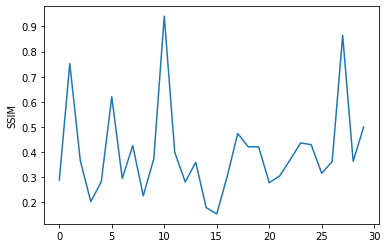

In [22]:
#input shape
image_shape = (256, 256, 3)

#number of images
n_images = 12754

ssim_score = []
rmse_score = []
d1_loss = []
d2_loss = []
gen_loss = []

# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

# train model
train(d_model, g_model, gan_model, n_images)

plt.plot(ssim_score)
plt.ylabel('SSIM')
plt.show

In [23]:
# print(ssim_score[5])
# plt.plot(ssim_score)
# plt.ylabel('SSIM')
# plt.show